In [1]:
import os
import cv2 as cv
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import keras

from tensorflow.keras.models import Model,  Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG19

In [2]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout, BatchNormalization, Activation
from sklearn.metrics import confusion_matrix , classification_report, accuracy_score, recall_score, precision_score, f1_score

In [3]:
train_path = 'data/train'
val_path = 'data/val'
test_path = 'data/test'

fake


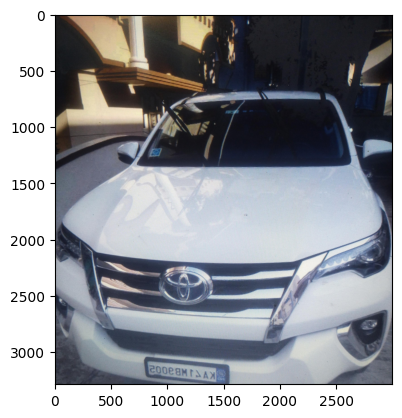

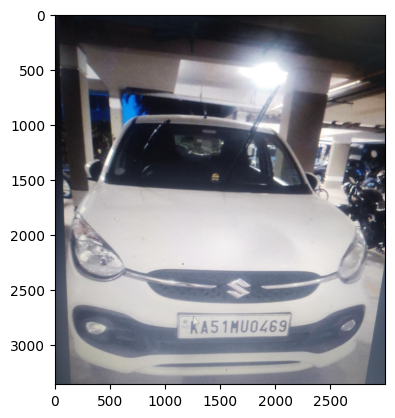

real


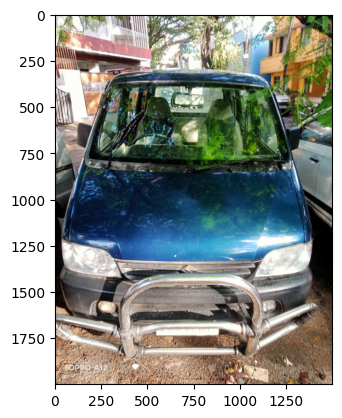

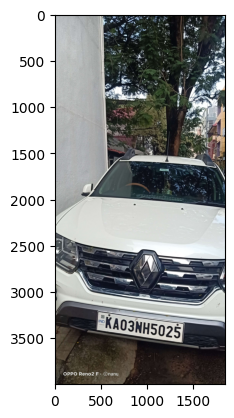

In [4]:
for folder in os.listdir(train_path):
    sub_path = train_path + "/" + folder
    print(folder)
    for i in range(2):
        temp_path = os.listdir(sub_path)[i]
        temp_path = sub_path + "/" + temp_path
        img = mpimg.imread(temp_path)
        implot = plt.imshow(img)
        plt.show()

Converting image to pixels

In [5]:
def imagearray(path,size):
    data = []
    for folder in os.listdir(path):
        sub_path = path +"/" + folder
        for img in os.listdir(sub_path):
            image_path = sub_path + "/" + img
            img_arr = cv.imread(image_path)
            img_arr = cv.resize(img_arr, size)
            data.append(img_arr)
    return data

In [6]:
size = (250,250)

In [7]:
%%time
train = imagearray(train_path,size)
val = imagearray(val_path,size)
test = imagearray(test_path,size)

CPU times: total: 1min 2s
Wall time: 1min 58s


Normalisation

In [8]:
x_train = np.array(train)
x_val   = np.array(val)
x_test  = np.array(test)

In [9]:
x_train = x_train/255
x_val   = x_val/255
x_test  = x_test/255

Defining Target variables

In [10]:
def data_class(data_path, size, class_mode):
    datagen = ImageDataGenerator(rescale=1./255)
    classes = datagen.flow_from_directory(data_path, target_size= size, batch_size = 32, class_mode = class_mode)
    return classes

In [11]:
train_class = data_class(train_path, size,"sparse")
val_class   = data_class(val_path, size, "sparse")
test_class  = data_class(test_path, size, "sparse")

Found 1890 images belonging to 2 classes.
Found 405 images belonging to 2 classes.
Found 405 images belonging to 2 classes.


In [12]:
y_train = train_class.classes
y_val = val_class.classes
y_test = test_class.classes

In [13]:
train_class.class_indices

{'fake': 0, 'real': 1}

In [14]:
print(y_train.shape,y_val.shape)

(1890,) (405,)


VGG 19

In [15]:
vgg = VGG19(input_shape = (250,250,3) , weights = "imagenet" , include_top = False)

In [16]:
for layer in vgg.layers:
    layer.trainable = False

In [17]:
x = Flatten()(vgg.output)
prediction = Dense(3, activation = "softmax")(x)

In [18]:
model = Model(inputs = vgg.input, outputs = prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 250, 250, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 250, 250, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 250, 250, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 125, 125, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 125, 125, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 125, 125, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 62, 62, 128)       0     

In [19]:
early_stop = EarlyStopping(monitor = "val_loss" , mode= "min", verbose=1, patience = 5)

In [20]:
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = "adam",
              metrics = ["accuracy"])

In [21]:
history = model.fit(x_train,y_train,
          validation_data = (x_val,y_val),
          epochs = 10,
          callbacks = [early_stop],
          batch_size = 30,
          shuffle = True)

Epoch 1/10
63/63 [==============================] - 263s 4s/step - loss: 0.3979 - accuracy: 0.8280 - val_loss: 0.1737 - val_accuracy: 0.9259
Epoch 2/10
63/63 [==============================] - 264s 4s/step - loss: 0.0823 - accuracy: 0.9799 - val_loss: 0.1252 - val_accuracy: 0.9432
Epoch 3/10
63/63 [==============================] - 268s 4s/step - loss: 0.0517 - accuracy: 0.9947 - val_loss: 0.1042 - val_accuracy: 0.9531
Epoch 4/10
63/63 [==============================] - 265s 4s/step - loss: 0.0300 - accuracy: 0.9974 - val_loss: 0.0938 - val_accuracy: 0.9679
Epoch 5/10
63/63 [==============================] - 264s 4s/step - loss: 0.0198 - accuracy: 0.9989 - val_loss: 0.0902 - val_accuracy: 0.9580
Epoch 6/10
63/63 [==============================] - 263s 4s/step - loss: 0.0142 - accuracy: 1.0000 - val_loss: 0.0916 - val_accuracy: 0.9506
Epoch 7/10
63/63 [==============================] - 262s 4s/step - loss: 0.0121 - accuracy: 1.0000 - val_loss: 0.0901 - val_accuracy: 0.9531
Epoch 8/10
63

In [22]:
# Assuming 'model' is your trained Keras model
model.save('your_model_name.h5')

C:\Users\naman\.conda\envs\cuda_env\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Visualisation

TypeError: show() got an unexpected keyword argument 'label'

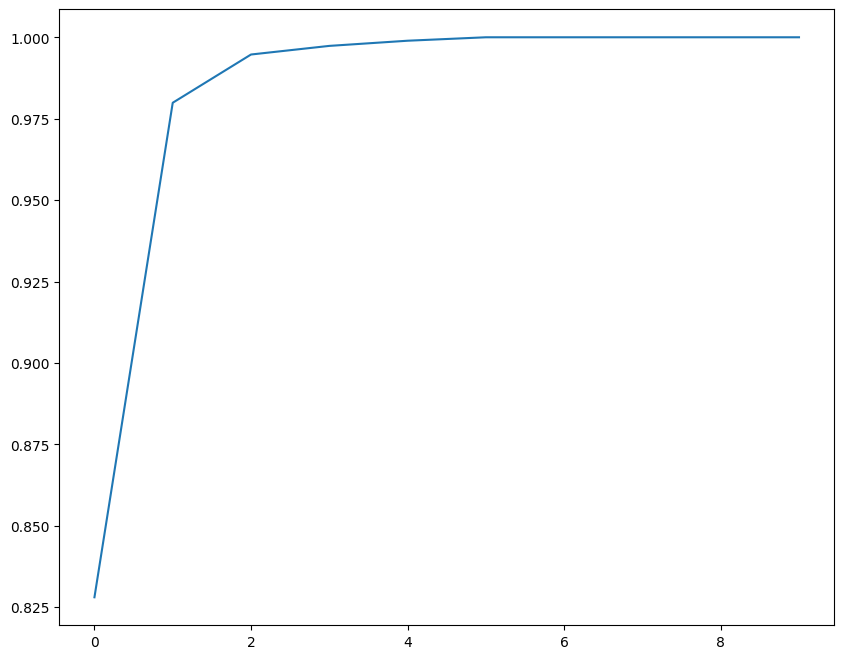

In [23]:
plt.figure(figsize=(10,8))
plt.plot(history.history['accuracy'], label = 'train acc')
plt.show(history.history['val_accuracy'], label = 'val acc')
plt.legend()
plt.title("Accuracy")
plt.show()

Text(0.5, 1.0, 'loss')

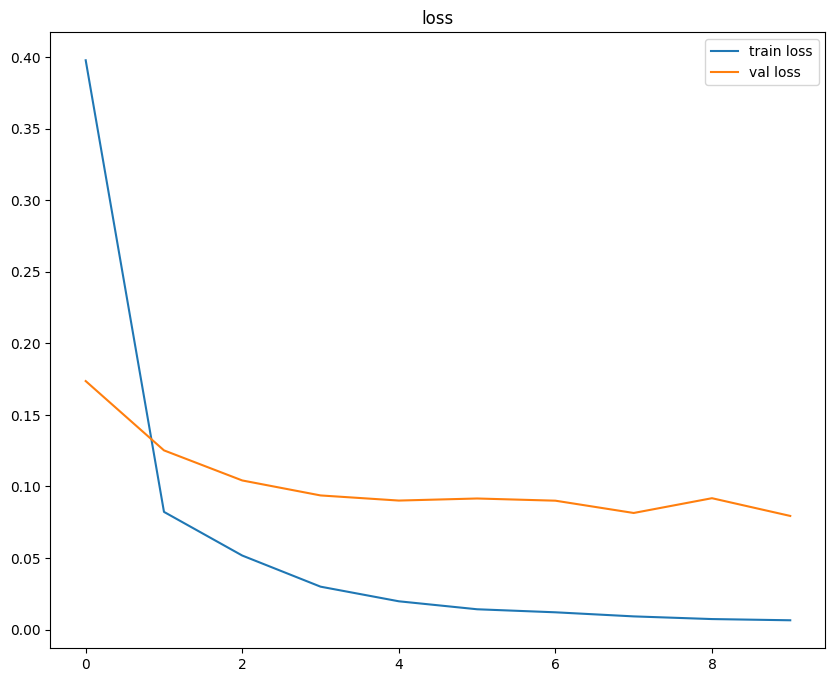

In [24]:
plt.figure(figsize = (10,8))
plt.plot(history.history['loss'], label = 'train loss')
plt.plot(history.history['val_loss'], label = 'val loss')
plt.legend()
plt.title('loss')

In [25]:
model.evaluate(x_test, y_test, batch_size = 32)

13/13 [==============================] - 45s 3s/step - loss: 0.0640 - accuracy: 0.9728


[0.06395415216684341, 0.9728395342826843]

In [26]:
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

13/13 [==============================] - 47s 4s/step


In [27]:
classification_report(y_pred,y_test)

'              precision    recall  f1-score   support\n\n           0       0.98      0.96      0.97       183\n           1       0.97      0.98      0.98       222\n\n    accuracy                           0.97       405\n   macro avg       0.97      0.97      0.97       405\nweighted avg       0.97      0.97      0.97       405\n'

In [28]:
f1_score(y_test,y_pred, average = 'micro')

0.9728395061728395

In [29]:
recall_score(y_test, y_pred, average ='weighted')

0.9728395061728395

In [30]:
precision_score(y_test, y_pred, average='micro')

0.9728395061728395